# BG-NBD ve Gamma-Gamma ile CLTV Tahmini

In [1]:
# BG-NBD ve Gamma-Gamma ile CLTV Tahmini
# #----------------------------------------------------------------------------------------------------------------------------#

# İş Problemi

#     FLO satış ve pazarlama faaliyetleri için roadmap 
#     belirlemek istemektedir. Şirketin orta uzun vadeli plan 
#     yapabilmesi için var olan müşterilerin gelecekte şirkete
#     sağlayacakları potansiyel değerin tahmin edilmesi
#     gerekmektedir.
# #----------------------------------------------------------------------------------------------------------------------------#
# Veri Seti Hikayesi

#     Veri seti Flo’dan son alışverişlerini 2020 - 2021 yıllarında OmniChannel (hem online hem offline alışveriş yapan) 
#     olarak yapan müşterilerin geçmiş alışveriş davranışlarından elde edilen bilgilerden oluşmaktadır. 
    
#     13 Değişken 19.945 Gözlem 2.7MB
    
#     master_id Eşsiz müşteri numarası
#     order_channel Alışveriş yapılan platforma ait hangi kanalın kullanıldığı (Android, ios, Desktop, Mobile)
#     last_order_channel En son alışverişin yapıldığı kanal
#     first_order_date Müşterinin yaptığı ilk alışveriş tarihi
#     last_order_date Müşterinin yaptığı son alışveriş tarihi
#     last_order_date_online Müşterinin online platformda yaptığı son alışveriş tarihi
#     last_order_date_offline Müşterinin offline platformda yaptığı son alışveriş tarihi
#     order_num_total_ever_online Müşterinin online platformda yaptığı toplam alışveriş sayısı
#     order_num_total_ever_offline Müşterinin offline'da yaptığı toplam alışveriş sayısı
#     customer_value_total_ever_offline Müşterinin offline alışverişlerinde ödediği toplam ücret
#     customer_value_total_ever_online Müşterinin online alışverişlerinde ödediği toplam ücret
#     interested_in_categories_12 Müşterinin son 12 ayda alışveriş yaptığı kategorilerin listesi
# #----------------------------------------------------------------------------------------------------------------------------#
# Proje Görevleri
# #----------------------------------------------------------------------------------------------------------------------------#
# Görev 1: Veriyi Hazırlama
    
#     Adım 1: flo_data_20K.csv verisini okuyunuz. 
#     Adım 2: Aykırı değerleri baskılamak için gerekli olan outlier_thresholds ve replace_with_thresholds fonksiyonlarını tanımlayınız. 
#     Not: cltv hesaplanırken frequency değerleri integer olması gerekmektedir.Bu nedenle alt ve üst limitlerini round() ile yuvarlayınız.
#     Adım 3: "order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", 
#     "customer_value_total_ever_online" değişkenlerinin aykırı değerleri varsa baskılayanız.
#     Adım 4: Omnichannel müşterilerin hem online'dan hem de offline platformlardan alışveriş yaptığını ifade etmektedir. Her bir müşterinin toplam
#     alışveriş sayısı ve harcaması için yeni değişkenler oluşturunuz.
#     Adım 5: Değişken tiplerini inceleyiniz. Tarih ifade eden değişkenlerin tipini date'e çeviriniz.

# #----------------------------------------------------------------------------------------------------------------------------#
# Görev 2: CLTV Veri Yapısının Oluşturulması
    
#     Adım 1: Veri setindeki en son alışverişin yapıldığı tarihten 2 gün sonrasını analiz tarihi olarak alınız.
#     Adım 2: customer_id, recency_cltv_weekly, T_weekly, frequency ve monetary_cltv_avg değerlerinin yer aldığı yeni bir cltv dataframe'i oluşturunuz. 
#     Monetary değeri satın alma başına ortalama değer olarak, recency ve tenure değerleri ise haftalık cinsten ifade edilecek.
# #----------------------------------------------------------------------------------------------------------------------------#

# Görev 3: BG/NBD, Gamma-Gamma Modellerinin Kurulması ve CLTV’nin Hesaplanması
    
#     Adım 1: BG/NBD modelini fit ediniz.
#         • 3 ay içerisinde müşterilerden beklenen satın almaları tahmin ediniz ve exp_sales_3_month olarak cltv
#         dataframe'ine ekleyiniz.
#         • 6 ay içerisinde müşterilerden beklenen satın almaları tahmin ediniz ve exp_sales_6_month olarak cltv
#         dataframe'ine ekleyiniz.        

#     Adım 2: Gamma-Gamma modelini fit ediniz. Müşterilerin ortalama bırakacakları değeri tahminleyip exp_average_value olarak cltv
#     dataframe'ine ekleyiniz.
#     Adım 3: 6 aylık CLTV hesaplayınız ve cltv ismiyle dataframe'e ekleyiniz. 
#         • Cltv değeri en yüksek 20 kişiyi gözlemleyiniz.
# #----------------------------------------------------------------------------------------------------------------------------#

# Görev 4: CLTV Değerine Göre Segmentlerin Oluşturulması

#     Adım 1: 6 aylık CLTV'ye göre tüm müşterilerinizi 4 gruba (segmente) ayırınız ve grup isimlerini veri setine ekleyiniz. 
#     Adım 2: 4 grup içerisinden seçeceğiniz 2 grup için yönetime kısa kısa 6 aylık aksiyon önerilerinde bulununuz.
# #----------------------------------------------------------------------------------------------------------------------------#

In [2]:
##########################
# Gerekli Kütüphane ve Fonksiyonlar
##########################

# !pip install lifetimes
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions
from IPython.display import Image
from datetime import timedelta

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

In [3]:
# #----------------------------------------------------------------------------------------------------------------------------#
# Görev 1: Veriyi Hazırlama
    
#     Adım 1: flo_data_20K.csv verisini okuyunuz. 
#     Adım 2: Aykırı değerleri baskılamak için gerekli olan outlier_thresholds ve replace_with_thresholds fonksiyonlarını tanımlayınız. 
#     Not: cltv hesaplanırken frequency değerleri integer olması gerekmektedir.Bu nedenle alt ve üst limitlerini round() ile yuvarlayınız.
#     Adım 3: "order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", 
#     "customer_value_total_ever_online" değişkenlerinin aykırı değerleri varsa baskılayanız.
#     Adım 4: Omnichannel müşterilerin hem online'dan hem de offline platformlardan alışveriş yaptığını ifade etmektedir. 
#             Her bir müşterinin toplam alışveriş sayısı ve harcaması için yeni değişkenler oluşturunuz.
#     Adım 5: Değişken tiplerini inceleyiniz. Tarih ifade eden değişkenlerin tipini date'e çeviriniz.

# #----------------------------------------------------------------------------------------------------------------------------#


In [4]:
# #--------------------------------------------------------------------------------------------------------------------------#    
# Adım 1: flo_data_20K.csv verisini okuyunuz.Dataframe’in kopyasını oluşturunuz.
# #--------------------------------------------------------------------------------------------------------------------------#    
#df_ = pd.read_excel("datasets/online_retail_II.xlsx", sheet_name="Year 2009-2010") excel için örnek
path="C:\\Users\\Msı\\PycharmProjects\\DSMLBC9\WEEK_2\\Proje_1_FLO_RFM_Analizi\\flo_data_20K.csv"
df_ = pd.read_csv(path)


In [5]:
df = df_.copy()
df

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1.0000,139.9900,799.3800,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2.0000,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2.0000,189.9700,395.3500,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1.0000,39.9900,81.9800,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1.0000,49.9900,159.9900,[AKTIFSPOR]
...,...,...,...,...,...,...,...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,Android App,Offline,2019-09-21,2020-07-05,2020-06-05,2020-07-05,1.0000,2.0000,289.9800,111.9800,"[ERKEK, AKTIFSPOR]"
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,Desktop,Desktop,2020-03-01,2020-12-22,2020-12-22,2020-03-01,1.0000,1.0000,150.4800,239.9900,[AKTIFSPOR]
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,Ios App,Ios App,2019-09-11,2021-05-24,2021-05-24,2019-09-11,2.0000,1.0000,139.9800,492.9600,[AKTIFSPOR]
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,Android App,Android App,2019-03-27,2021-02-13,2021-02-13,2021-01-08,1.0000,5.0000,711.7900,297.9800,"[ERKEK, AKTIFSPOR]"


In [6]:
# df = df_.copy()
# df.describe().T
# df.head()
# df.isnull().sum()
# df

In [7]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)# normalde %25 yani 0.25 yazılır. biz veriye göre bu kararı verdik
    quartile3 = dataframe[variable].quantile(0.99)# normalde %75 yani 0.75 yazılır
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [8]:
df['order_num_total_ever_online']=df['order_num_total_ever_online'].astype(int)
df['order_num_total_ever_offline']=df['order_num_total_ever_offline'].astype(int)
df.head(3)

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4,1,139.9900,799.3800,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19,2,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3,2,189.9700,395.3500,"[ERKEK, KADIN]"


In [9]:
replace_with_thresholds(df, "order_num_total_ever_online")
replace_with_thresholds(df, "order_num_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_online")

In [10]:
df["customer_value_total"]=df["customer_value_total_ever_online"]+df["customer_value_total_ever_offline"]
df["order_num_total"]=(df["order_num_total_ever_online"]+df["order_num_total_ever_offline"]).astype(int)
df.head(3)

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,customer_value_total,order_num_total
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1,139.9900,799.3800,[KADIN],939.3700,5
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2013.5500,21
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2,189.9700,395.3500,"[ERKEK, KADIN]",585.3200,5


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  int32  
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [12]:
df[["first_order_date","last_order_date","last_order_date_online","last_order_date_offline"]]=df[["first_order_date","last_order_date","last_order_date_online","last_order_date_offline"]].astype('datetime64[ns]')
df

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,customer_value_total,order_num_total
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1,139.9900,799.3800,[KADIN],939.3700,5
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0000,2,159.9700,1853.5800,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",2013.5500,21
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0000,2,189.9700,395.3500,"[ERKEK, KADIN]",585.3200,5
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0000,1,39.9900,81.9800,"[AKTIFCOCUK, COCUK]",121.9700,2
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0000,1,49.9900,159.9900,[AKTIFSPOR],209.9800,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,Android App,Offline,2019-09-21,2020-07-05,2020-06-05,2020-07-05,1.0000,2,289.9800,111.9800,"[ERKEK, AKTIFSPOR]",401.9600,3
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,Desktop,Desktop,2020-03-01,2020-12-22,2020-12-22,2020-03-01,1.0000,1,150.4800,239.9900,[AKTIFSPOR],390.4700,2
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,Ios App,Ios App,2019-09-11,2021-05-24,2021-05-24,2019-09-11,2.0000,1,139.9800,492.9600,[AKTIFSPOR],632.9400,3
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,Android App,Android App,2019-03-27,2021-02-13,2021-02-13,2021-01-08,1.0000,5,711.7900,297.9800,"[ERKEK, AKTIFSPOR]",1009.7700,6


In [13]:
df["order_num_total"]=(df["order_num_total_ever_online"]+df["order_num_total_ever_offline"]).astype(int)
df["customer_value_total"]=df["customer_value_total_ever_offline"]+df["customer_value_total_ever_online"]
df.head(1)

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,customer_value_total,order_num_total
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1,139.9900,799.3800,[KADIN],939.3700,5


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   master_id                          19945 non-null  object        
 1   order_channel                      19945 non-null  object        
 2   last_order_channel                 19945 non-null  object        
 3   first_order_date                   19945 non-null  datetime64[ns]
 4   last_order_date                    19945 non-null  datetime64[ns]
 5   last_order_date_online             19945 non-null  datetime64[ns]
 6   last_order_date_offline            19945 non-null  datetime64[ns]
 7   order_num_total_ever_online        19945 non-null  float64       
 8   order_num_total_ever_offline       19945 non-null  int32         
 9   customer_value_total_ever_offline  19945 non-null  float64       
 10  customer_value_total_ever_online  

In [15]:
# #----------------------------------------------------------------------------------------------------------------------------#
# Görev 2: CLTV Veri Yapısının Oluşturulması
    
#     Adım 1: Veri setindeki en son alışverişin yapıldığı tarihten 2 gün sonrasını analiz tarihi olarak alınız.
#     Adım 2: customer_id, recency_cltv_weekly, T_weekly, frequency ve monetary_cltv_avg değerlerinin 
#             yer aldığı yeni bir cltv dataframe'i oluşturunuz. 
#     Monetary değeri satın alma başına ortalama değer olarak, recency ve tenure değerleri ise haftalık cinsten ifade edilecek.
# #----------------------------------------------------------------------------------------------------------------------------#


In [16]:
df["last_order_date"].max()   # son gün

Timestamp('2021-05-30 00:00:00')

In [19]:
#last_order_date_plus_2 günü çalışmayı yaptığımız gün olarak düşünüyoruz
last_order_date_plus_2 = df["last_order_date"].max()+timedelta(days=2)
last_order_date_plus_2

Timestamp('2021-06-01 00:00:00')

In [20]:
df.head(1)

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,customer_value_total,order_num_total
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0000,1,139.9900,799.3800,[KADIN],939.3700,5


In [21]:
cltv_df=pd.DataFrame()
cltv_df["customer_id"]=df["master_id"]
cltv_df["recency_cltv_weekly"]=(df["last_order_date"]-df["first_order_date"])/7 #müşterinin recency değerinihaftalığaçeviriyoruz
cltv_df["T_weekly"]=(last_order_date_plus_2-df["first_order_date"])/7  # müşteri yaşını haftalığa çeviriyoruz
cltv_df["frequency"]=df["order_num_total"]
cltv_df["monetary_cltv_avg"]=df["customer_value_total"]/ cltv_df["frequency"]   #işlem başına ort. kazancı bulduk

cltv_df.head(3)

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17 days 00:00:00,30 days 13:42:51.428571428,5,187.8740
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209 days 20:34:17.142857142,224 days 20:34:17.142857142,21,95.8833
2,69b69676-1a40-11ea-941b-000d3a38a36f,52 days 06:51:25.714285714,78 days 20:34:17.142857142,5,117.0640


In [22]:
cltv_df["T_weekly"]=[i.days for i in cltv_df["T_weekly"]]
cltv_df["recency_cltv_weekly"]=[i.days for i in cltv_df["recency_cltv_weekly"]]
cltv_df

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17,30,5,187.8740
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209,224,21,95.8833
2,69b69676-1a40-11ea-941b-000d3a38a36f,52,78,5,117.0640
3,1854e56c-491f-11eb-806e-000d3a38a36f,1,20,2,60.9850
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83,95,2,104.9900
...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,41,88,3,133.9867
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,42,65,2,195.2350
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,88,89,3,210.9800
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,98,113,6,168.2950


In [23]:
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]    # frekansı 1 den fazla olanları alıyoruz

In [24]:
# #----------------------------------------------------------------------------------------------------------------------------#

# Görev 3: BG/NBD, Gamma-Gamma Modellerinin Kurulması ve CLTV’nin Hesaplanması
    
#     Adım 1: BG/NBD modelini fit ediniz.
#         • 3 ay içerisinde müşterilerden beklenen satın almaları tahmin ediniz ve exp_sales_3_month olarak cltv
#         dataframe'ine ekleyiniz.
#         • 6 ay içerisinde müşterilerden beklenen satın almaları tahmin ediniz ve exp_sales_6_month olarak cltv
#         dataframe'ine ekleyiniz.        

#     Adım 2: Gamma-Gamma modelini fit ediniz. Müşterilerin ortalama bırakacakları değeri tahminleyip exp_average_value olarak cltv
#     dataframe'ine ekleyiniz.
#     Adım 3: 6 aylık CLTV hesaplayınız ve cltv ismiyle dataframe'e ekleyiniz. 
#         • Cltv değeri en yüksek 20 kişiyi gözlemleyiniz.
# #----------------------------------------------------------------------------------------------------------------------------#


In [25]:
cltv_df.head(1)

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17,30,5,187.8740


In [26]:
##############################################################
# 2. BG-NBD Modelinin Kurulması
##############################################################

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(cltv_df['frequency'],
        cltv_df['recency_cltv_weekly'],
        cltv_df['T_weekly'])


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 75.49, b: 0.00, r: 3.65>

In [27]:
cltv_df["expected_purc_3_month"] = bgf.predict(4*3,
                                               cltv_df['frequency'],
                                               cltv_df['recency_cltv_weekly'],
                                               cltv_df['T_weekly'])

cltv_df["expected_purc_6_month"] = bgf.predict(4*6,
                                               cltv_df['frequency'],
                                               cltv_df['recency_cltv_weekly'],
                                               cltv_df['T_weekly'])
cltv_df

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,expected_purc_3_month,expected_purc_6_month
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17,30,5,187.8740,0.9839,1.9678
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209,224,21,95.8833,0.9876,1.9753
2,69b69676-1a40-11ea-941b-000d3a38a36f,52,78,5,117.0640,0.6762,1.3524
3,1854e56c-491f-11eb-806e-000d3a38a36f,1,20,2,60.9850,0.7099,1.4199
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83,95,2,104.9900,0.3976,0.7953
...,...,...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,41,88,3,133.9867,0.4881,0.9761
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,42,65,2,195.2350,0.4825,0.9651
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,88,89,3,210.9800,0.4851,0.9702
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,98,113,6,168.2950,0.6143,1.2286


In [28]:
# #----------------------------------------------------------------------------------------------------------------------------#
#     Adım 2: Gamma-Gamma modelini fit ediniz. Müşterilerin ortalama bırakacakları değeri tahminleyip exp_average_value olarak cltv
#     dataframe'ine ekleyiniz.
#     Adım 3: 6 aylık CLTV hesaplayınız ve cltv ismiyle dataframe'e ekleyiniz. 
#         • Cltv değeri en yüksek 20 kişiyi gözlemleyiniz.
# #----------------------------------------------------------------------------------------------------------------------------#


In [29]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

ggf.fit(cltv_df['frequency'], cltv_df['monetary_cltv_avg'])

<lifetimes.GammaGammaFitter: fitted with 19945 subjects, p: 4.15, q: 0.47, v: 4.08>

In [30]:
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary_cltv_avg']).sort_values(ascending=False).head(10)

9055    1449.0300
17323   1127.6115
15516   1127.3545
6402     923.6800
16410    920.3579
1853     895.0369
7936     883.2880
9738     875.6741
12828    834.5676
2291     816.6633
dtype: float64

In [31]:
cltv_df["exp_average_value"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                            cltv_df['monetary_cltv_avg'])
cltv_df

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,expected_purc_3_month,expected_purc_6_month,exp_average_value
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17,30,5,187.8740,0.9839,1.9678,193.6327
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209,224,21,95.8833,0.9876,1.9753,96.6650
2,69b69676-1a40-11ea-941b-000d3a38a36f,52,78,5,117.0640,0.6762,1.3524,120.9676
3,1854e56c-491f-11eb-806e-000d3a38a36f,1,20,2,60.9850,0.7099,1.4199,67.3201
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83,95,2,104.9900,0.3976,0.7953,114.3251
...,...,...,...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,41,88,3,133.9867,0.4881,0.9761,141.3604
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,42,65,2,195.2350,0.4825,0.9651,210.7224
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,88,89,3,210.9800,0.4851,0.9702,221.7752
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,98,113,6,168.2950,0.6143,1.2286,172.6475


In [32]:
cltv = ggf.customer_lifetime_value(bgf,
                                   cltv_df['frequency'],
                                   cltv_df['recency_cltv_weekly'],
                                   cltv_df['T_weekly'],
                                   cltv_df['monetary_cltv_avg'],
                                   time=6,  # 6 aylık     # buradaki time değeri aylıktır
                                   freq="W",  # T'nin frekans bilgisi.(recency ve frequency değerleri hangi cinsten zamana göre)
                                   discount_rate=0.0) #zaman içinde sattılacak ürünlerde yapılacak indirim miktarı

cltv.head()

0   413.8917
1   207.4110
2   177.7100
3   103.8302
4    98.7609
Name: clv, dtype: float64

In [33]:
# eğer cltv, masterid değişkenine sahip olsa idi böyle yapabilirdik
# cltv = cltv.reset_index()
# cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")
# cltv

In [34]:
cltv_final = pd.concat([cltv_df, cltv], axis=1)
cltv_final.sort_values(by="clv", ascending=False).head(20)

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,expected_purc_3_month,expected_purc_6_month,exp_average_value,clv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2,7,4,1401.7705,1.1127,2.2255,1449.0300,3502.9511
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6,13,11,758.0437,1.9865,3.9731,767.3184,3311.5461
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51,101,7,1106.4671,0.7241,1.4481,1127.6115,1773.7884
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74,74,16,501.8451,1.5773,3.1546,506.1377,1734.3649
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62,67,52,166.2158,4.6865,9.3730,166.7034,1697.2806
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3,34,8,601.2262,1.2767,2.5535,611.4926,1696.1064
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8,9,2,862.6900,0.8024,1.6047,923.6800,1610.0934
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9,13,17,259.8653,2.8002,5.6003,262.0729,1594.2788
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52,58,31,228.5300,3.1147,6.2295,229.6069,1553.6918
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14,15,3,743.5867,0.8818,1.7635,778.0504,1490.4664


In [35]:
# #----------------------------------------------------------------------------------------------------------------------------#

# Görev 4: CLTV Değerine Göre Segmentlerin Oluşturulması

#     Adım 1: 6 aylık CLTV'ye göre tüm müşterilerinizi 4 gruba (segmente) ayırınız ve grup isimlerini veri setine ekleyiniz. 
#     Adım 2: 4 grup içerisinden seçeceğiniz 2 grup için yönetime kısa kısa 6 aylık aksiyon önerilerinde bulununuz.
# #----------------------------------------------------------------------------------------------------------------------------#

In [36]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])
cltv_final

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,expected_purc_3_month,expected_purc_6_month,exp_average_value,clv,segment
0,cc294636-19f0-11eb-8d74-000d3a38a36f,17,30,5,187.8740,0.9839,1.9678,193.6327,413.8917,A
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,209,224,21,95.8833,0.9876,1.9753,96.6650,207.4110,B
2,69b69676-1a40-11ea-941b-000d3a38a36f,52,78,5,117.0640,0.6762,1.3524,120.9676,177.7100,B
3,1854e56c-491f-11eb-806e-000d3a38a36f,1,20,2,60.9850,0.7099,1.4199,67.3201,103.8302,D
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,83,95,2,104.9900,0.3976,0.7953,114.3251,98.7609,D
...,...,...,...,...,...,...,...,...,...,...
19940,727e2b6e-ddd4-11e9-a848-000d3a38a36f,41,88,3,133.9867,0.4881,0.9761,141.3604,149.8848,C
19941,25cd53d4-61bf-11ea-8dd8-000d3a38a36f,42,65,2,195.2350,0.4825,0.9651,210.7224,220.9052,B
19942,8aea4c2a-d6fc-11e9-93bc-000d3a38a36f,88,89,3,210.9800,0.4851,0.9702,221.7752,233.7193,B
19943,e50bb46c-ff30-11e9-a5e8-000d3a38a36f,98,113,6,168.2950,0.6143,1.2286,172.6475,230.4147,B


In [37]:
cltv_final.sort_values(by="clv", ascending=False).head(5)

,customer_id,recency_cltv_weekly,T_weekly,frequency,monetary_cltv_avg,expected_purc_3_month,expected_purc_6_month,exp_average_value,clv,segment
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2,7,4,1401.7705,1.1127,2.2255,1449.0300,3502.9511,A
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6,13,11,758.0437,1.9865,3.9731,767.3184,3311.5461,A
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51,101,7,1106.4671,0.7241,1.4481,1127.6115,1773.7884,A
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74,74,16,501.8451,1.5773,3.1546,506.1377,1734.3649,A
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62,67,52,166.2158,4.6865,9.3730,166.7034,1697.2806,A


In [38]:
cltv_final.groupby("segment").agg(
    {"count", "mean", "sum"})


recency_cltv_weekly               T_weekly               frequency              monetary_cltv_avg                    expected_purc_3_month                 expected_purc_6_month                 exp_average_value                         clv                   
                       mean count     sum     mean count     sum      mean count    sum              mean count          sum                  mean count       sum                  mean count       sum              mean count          sum     mean count          sum
segment                                                                                                                                                                                                                                                                  
D                  138.7121  4987  691757 161.9146  4987  807468    3.7700  4987  18801           93.2319  4987  464947.4944                0.4101  4987 2045.0597                0.8202  4987 4090.1194           98.7738  4987  492584.7575  83.4688  4987  416258.9653
C                   92.2310  4986  459864 112.4649  4986  560750    4.4065  4986  21971          125.8636  4986  627555.9587                0.5277  4986 2631.1861                1.0554  4986 5262.3723          132.3273  4986  659783.9262 143.8363  4986  717167.9002
B                   81.5068  4986  406393  99.7866  4986  497536    5.0979  4986  25418          160.4792  4986  800149.3038                0.6049  4986 3016.0600                1.2098  4986 6032.1200          167.8286  4986  836793.3583 207.6169  4986 1035178.0998
A                   66.8907  4986  333517  82.0154  4986  408929    6.6384  4986  33099          228.8331  4986 1140961.6157                0.7777  4986 3877.6911                1.5554  4986 7755.3822          238.0365  4986 1186850.0103 377.4369  4986 1881900.4732

In [39]:
#     Adım 2: 4 grup içerisinden seçeceğiniz 2 grup için yönetime kısa kısa 6 aylık aksiyon önerilerinde bulununuz.


In [40]:
# eksik veri hatalı modele, hatalı model hatalı kararlara sebep olur. Bu nedenle modelin doğruluğunun kontrol edilmesi erekiyor.
# ancak bizden öneri beklendiği için model doğrulanmış varsayıyorum

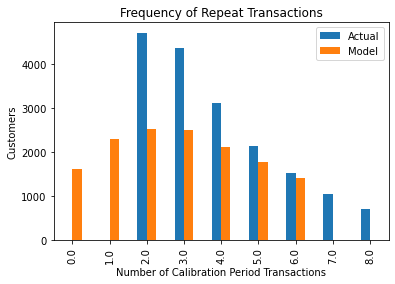

In [41]:
################################################################
# Tahmin Sonuçlarının Değerlendirilmesi
################################################################

plot_period_transactions(bgf)
plt.show()
# sonuçlara bakınca bazı frekanslarda yüksek hatalar mevcut. 
# bu frekans aralığı için hata payı daha yüksek olacağı göz önüne alınmalı 

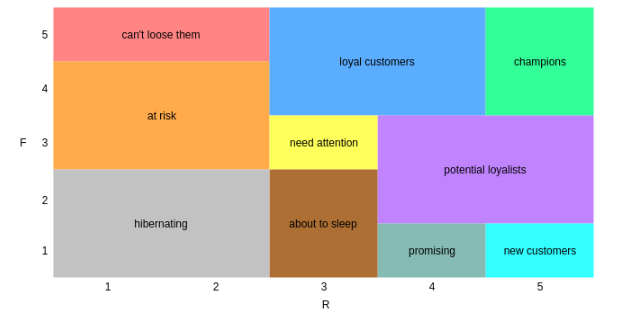

In [42]:
Image("C:\\Users\\Msı\\PycharmProjects\\DSMLBC9\WEEK_2\\Proje_2_FLO_CLTV_Tahmini\\segments.png")

In [ ]:
# Cevap
# Bu veri setinde oluşturduğumuz A segmentini şampiyonlar olarak belirleyebiliriz.Bu kesim getirisi en fazla olan. 
# Bu müşterileri kaybetmememiz için gerekli önlemler alınmalı,


# C segmenti ise frekansı en düşük ve de frekansı en az olan bu segment için ise 
# hatırlatmalar yapılmalı bazı ilgi çekici kampanyalar düzenlenmeli.